<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/inside-deep-learing/12-rnn-alternatives/01_torchtext_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Torch text basic

Recurrent neural networks—in particular, LSTMs—have been used for classifying and
working with sequence problems for over two decades. While they have long been
reliable tools for the task, they have several undesirable properties. 

* RNNs are just plain 
* they do not scale well with more layers or with more GPUs

With skip connections and residual
layers, we have learned about many ways to get fully connected and convolutional
networks to train with more layers to get better results. 

But RNNs just do not seem to
like being deep. You can add more layers and skip connections, but they do not show
the same degree of benefits as improved accuracy.

So, we look at some methods that can help us with one or both of these
problems.

* we tackle the slowness of RNNs by violating our prior beliefs.
* we look at a different way of representing the sequential component of our data to augment these faster alternatives and regain some of our accuracy.
* Finally, we learn about transformers.



##Setup

In [ ]:
!pip install portalocker

In [ ]:
!wget https://github.com/EdwardRaff/Inside-Deep-Learning/raw/main/idlmam.py

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torchvision import transforms

import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import vocab

from torchtext.datasets import AG_NEWS

from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm

from collections import Counter
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score

import time
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import re

from idlmam import set_seed
from idlmam import LastTimeStep, train_network, Flatten, weight_reset, View, LambdaLayer
from idlmam import AttentionAvg, GeneralScore, DotScore, AdditiveAttentionScore #For attention mechanism use

In [ ]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

from IPython.display import display_pdf
from IPython.display import Latex

In [5]:
torch.backends.cudnn.deterministic=True
set_seed(42)

In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [7]:
import warnings
warnings.filterwarnings("ignore")

##AG News dataset

In [8]:
# let’s quickly load AG_NEWS dataset
train_iter, test_iter = AG_NEWS(root="./data", split=("train", "test"))

train_dataset = list(train_iter)
test_dataset = list(test_iter)

In [9]:
print(train_dataset[0])

(3, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")


In [10]:
# tokenizers break strings like "this is a string" into lists of tokens like ['this', 'is', 'a', 'string']
tokenizer = get_tokenizer("basic_english") # we will be fine with the default english style tokenizer

# we need to create a vocabulary of all the words in the training set
counter = Counter()
for (label, line) in train_dataset:
  # count the number of unique tokens we see and how often we see them (e.g., we will see "the" a lot, but "sasquatch" maybe once or not at all.)
  counter.update(tokenizer(line))
# create a vocab object, removing any word that didn't occur at least 10 times, 
# and add special vocab items for unkown, begining of sentance, end of sentance, and "padding"
vocab = vocab(counter, min_freq=10, specials=("<unk>", "<BOS>", "<EOS>", "<PAD>"))
vocab.set_default_index(vocab["<unk>"])

In [11]:
len(vocab)

20647

In [12]:
def text_transform(x):
  # vocab acts like a dictionary, handls unkown tokens.
  # We can make it pre- and post-pend with the start and end markers, respectively.
  return [vocab["<BOS>"]] + [vocab[token] for token in tokenizer(x)] + [vocab["<EOS>"]]

def label_transform(y):
  # labes are originally [1, 2, 3, 4] but we need them as [0, 1, 2, 3] 
  return y - 1

In [13]:
train_dataset[0][1]

"Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again."

In [14]:
# let's transform the first data point's text into a list of tokens
print(text_transform(train_dataset[0][1]))

[1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 14, 16, 0, 17, 4, 18, 19, 20, 0, 21, 0, 17, 22, 23, 24, 25, 6, 2]


In [15]:
# To make training faster, let’s limit ourselves to sentences that contain six or fewer words.
VOCAB_SIZE  = len(vocab)
NUM_CLASS = len(np.unique([z[0] for z in train_dataset]))
print(f"Vocab: {VOCAB_SIZE}")
print(f"Num Classes: {NUM_CLASS}")

padding_idx = vocab["<PAD>"]
embed_dim = 128
B = 64
epochs = 15

Vocab: 20647
Num Classes: 4


In [16]:
def pad_batch(batch):
  """
  Pad items in the batch to the length of the longest item in the batch. 
  Also, re-order so that the values are returned (input, label)
  """
  # transform every label in the batch
  labels = [label_transform(z[0]) for z in batch]
  # tokenizes every text and puts them into a tensor
  texts = [torch.tensor(text_transform(z[1]), dtype=torch.int64) for z in batch]

  # what is the longest sequence in this batch?
  max_len = max([text.size(0) for text in texts])
  # pad each text tensor by whatever amount gets it to the max_len
  texts = [F.pad(text, (0, max_len - text.size(0)), value=padding_idx) for text in texts]
  # make x and y a single tensor
  x, y = torch.stack(texts), torch.tensor(labels, dtype=torch.int64)
  return  x, y

In [17]:
# Now we can build our DataLoaders
train_loader = DataLoader(train_dataset, batch_size=B, shuffle=True, collate_fn=pad_batch)
test_loader = DataLoader(test_dataset, batch_size=B, collate_fn=pad_batch)

In [18]:
iterator = iter(train_loader)

batch1 = next(iterator)

In [19]:
batch1

(tensor([[    1,  7034,  9930,  ...,     3,     3,     3],
         [    1,   721,  1952,  ...,     3,     3,     3],
         [    1,  1814,  1104,  ...,     3,     3,     3],
         ...,
         [    1, 20355,  3099,  ...,     3,     3,     3],
         [    1,    11,   386,  ...,     3,     3,     3],
         [    1,     0,    17,  ...,     3,     3,     3]]),
 tensor([1, 3, 3, 3, 1, 2, 0, 2, 1, 3, 3, 2, 2, 2, 2, 2, 0, 3, 1, 1, 3, 2, 3, 3,
         1, 1, 0, 2, 3, 3, 2, 3, 3, 2, 1, 0, 1, 3, 3, 1, 3, 1, 2, 1, 1, 3, 1, 2,
         3, 0, 1, 3, 1, 3, 1, 3, 0, 2, 3, 0, 1, 1, 3, 0]))

##Baseline model

Let’s start by implementing a baseline RNN model to which we can compare
each alternative, giving us a barometer to judge pros and cons.

In [20]:
gru = nn.Sequential(
  nn.Embedding(VOCAB_SIZE, embed_dim, padding_idx=padding_idx),  # (B, T) -> (B, T, D)
  nn.GRU(embed_dim, embed_dim, num_layers=3, batch_first=True, bidirectional=True), # (B, T, D) -> ( (B,T,D) , (S, B, D)  )
  LastTimeStep(rnn_layers=3, bidirectional=True), # We need to take the RNN output and reduce it to one item, (B, 2*D)
  nn.Linear(embed_dim * 2, NUM_CLASS)    # (B, D) -> (B, classes)
)

loss_func = nn.CrossEntropyLoss()

In [ ]:
gru_results = train_network(gru, 
                            loss_func, 
                            train_loader, 
                            val_loader=test_loader, 
                            score_funcs={'Accuracy': accuracy_score}, 
                            device=device, epochs=epochs)

<Axes: xlabel='epoch', ylabel='val Accuracy'>

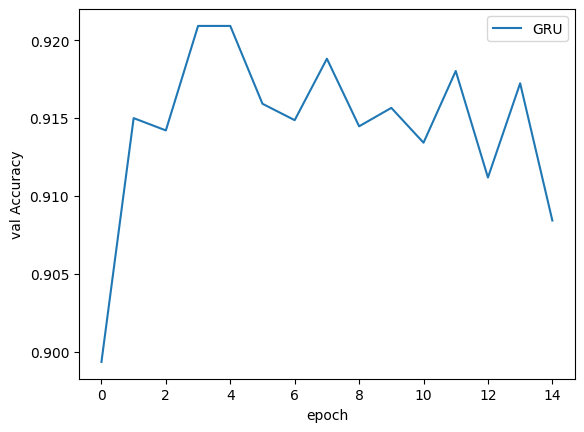

In [22]:
sns.lineplot(x="epoch", y="val Accuracy", data=gru_results, label="GRU")

##Averaging embeddings over time

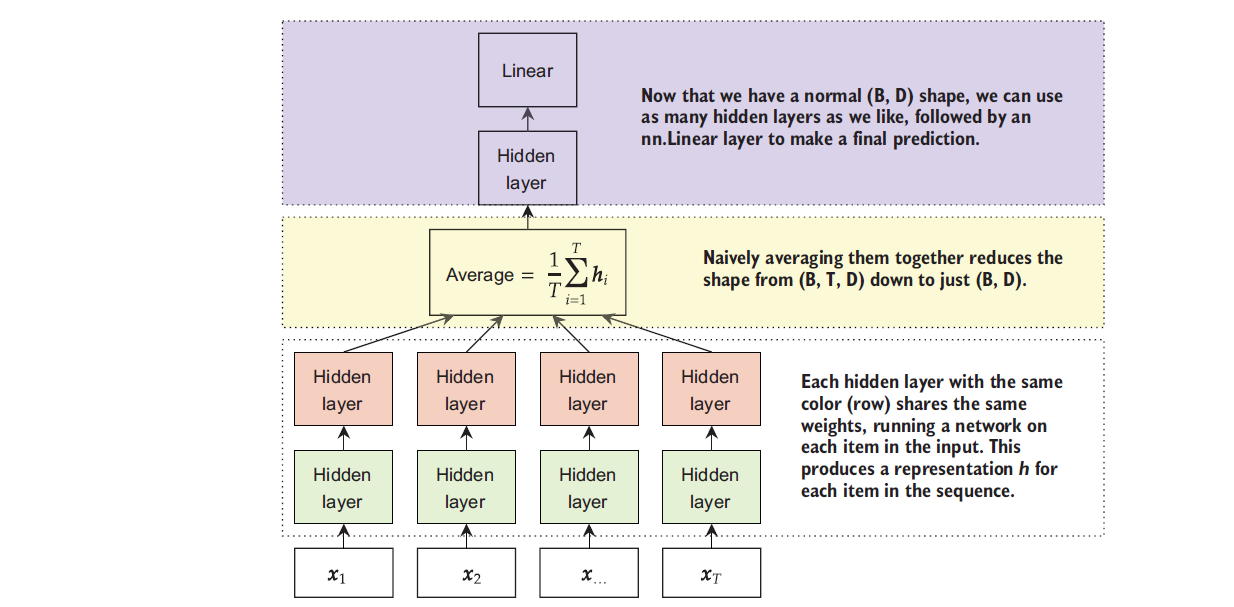

In [25]:
simple_emb_average = nn.Sequential(
  nn.Embedding(VOCAB_SIZE, embed_dim, padding_idx=padding_idx),  # (B, T) -> (B, T, D)

  nn.Linear(embed_dim, embed_dim),
  nn.LeakyReLU(),
  nn.Linear(embed_dim, embed_dim),
  nn.LeakyReLU(),
  nn.Linear(embed_dim, embed_dim),
  nn.LeakyReLU(),

  nn.AdaptiveAvgPool2d((1, embed_dim)),  # (B, T, D) -> (B, 1, D)
  nn.Flatten(),                          # (B, 1, D) -> (B, D)

  nn.Linear(embed_dim, embed_dim),
  nn.LeakyReLU(),

  nn.BatchNorm1d(embed_dim),
  nn.Linear(embed_dim, NUM_CLASS)
)

In [ ]:
simple_emb_average_results = train_network(simple_emb_average, 
                            loss_func, 
                            train_loader, 
                            val_loader=test_loader, 
                            score_funcs={'Accuracy': accuracy_score}, 
                            device=device, epochs=epochs)

<Axes: xlabel='epoch', ylabel='val Accuracy'>

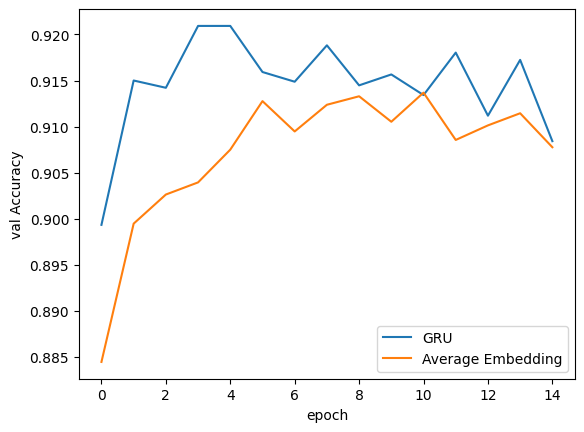

In [27]:
sns.lineplot(x="epoch", y="val Accuracy", data=gru_results, label="GRU")
sns.lineplot(x="epoch", y="val Accuracy", data=simple_emb_average_results, label="Average Embedding")

<Axes: xlabel='total time', ylabel='val Accuracy'>

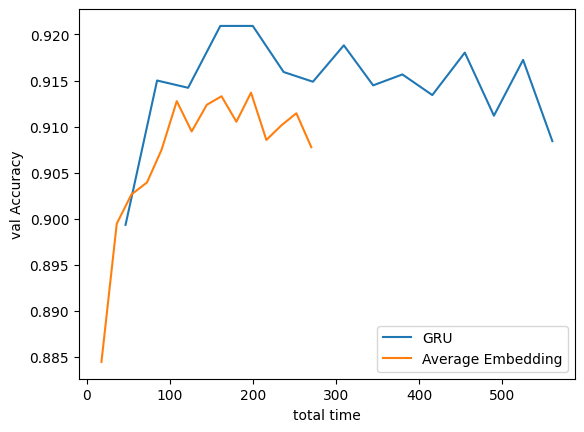

In [28]:
# it clear that training the average embeddings is around three times faster than the GRU model
sns.lineplot(x="total time", y="val Accuracy", data=gru_results, label="GRU")
sns.lineplot(x="total time", y="val Accuracy", data=simple_emb_average_results, label="Average Embedding")

##Weighted average over time with attention